In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

In [2]:
from src.utils.flow import *
from src.utils.flow_calculations import *
from src.utils.restoration import *
from src.utils.truncated_packet import *
from src.operations.size_perturbation_logic import *
from src.operations.timing_perturbation_logic import *
from src.operations.calculate_fitness import *

In [3]:
capture = "botnet-capture-20110811-neris" # test file


pcap_file_path = f'../data/raw/{capture}.pcap'

truncated_packets = create_truncated_packets_from_pcap(pcap_file_path)
print(f"Total packets loaded: {len(truncated_packets)}")

truncated_packets = assign_flow_ids_to_packets(truncated_packets)

# funkcja na sprawdzenie ile flow ids zostalo przypisane i jaki jest ich rozklad w zaleznosci od wielkosci danego flow
# oryg 21756




Total packets loaded: 175491
hash groups: 19002


In [4]:
truncated_packets[3]
# dlaczego id jest 5, a nie 1

TruncatedPacket(packet_id=7, timestamp=1313051628.479163, size=60, pseudo_hash='3495308735826817389', flow_id=2, direction='2', src_ip=147.32.84.171, fragmented=0, tcp=1, udp=0, fin=0, syn=0, rst=0, ack=1, psh=0, urg=0)

In [5]:
from collections import Counter

def analyze_flows(packets):
    # Tworzenie słownika do liczenia pakietów dla każdego flow_id
    flow_counts = Counter(packet.flow_id for packet in packets)
    print(len(flow_counts))
    
    
    # Wypisywanie liczby pakietów dla każdego flow_id
    for flow_id, count in flow_counts.items():
        print(f"Flow ID: {flow_id}, Number of Packets: {count}")
    
    # Zwracanie słownika z liczbami pakietów dla każdego flow_id
    return flow_counts


calculated_flows = analyze_flows(truncated_packets)

24147
Flow ID: 2, Number of Packets: 21
Flow ID: 4, Number of Packets: 26
Flow ID: 3, Number of Packets: 1
Flow ID: 13, Number of Packets: 116
Flow ID: 20, Number of Packets: 9
Flow ID: 21, Number of Packets: 2
Flow ID: 22, Number of Packets: 9
Flow ID: 24, Number of Packets: 9
Flow ID: 23, Number of Packets: 1
Flow ID: 25, Number of Packets: 1
Flow ID: 26, Number of Packets: 21
Flow ID: 27, Number of Packets: 2
Flow ID: 28, Number of Packets: 1
Flow ID: 32, Number of Packets: 33
Flow ID: 33, Number of Packets: 1
Flow ID: 34, Number of Packets: 156
Flow ID: 37, Number of Packets: 9
Flow ID: 38, Number of Packets: 2
Flow ID: 39, Number of Packets: 3
Flow ID: 40, Number of Packets: 3
Flow ID: 41, Number of Packets: 1
Flow ID: 45, Number of Packets: 53
Flow ID: 47, Number of Packets: 2
Flow ID: 48, Number of Packets: 5
Flow ID: 49, Number of Packets: 13
Flow ID: 51, Number of Packets: 2
Flow ID: 52, Number of Packets: 156
Flow ID: 54, Number of Packets: 3
Flow ID: 55, Number of Packets: 4

In [6]:
import pandas as pd

def read_and_sum_from_csv(file_path):
    # Wczytanie danych z pliku CSV
    df = pd.read_csv(file_path)
    
    # Sumowanie kolumn tot_bwd_pkts i tot_fwd_pkts
    df['total_packets'] = df['tot_bwd_pkts'] + df['tot_fwd_pkts']
    
    return df['total_packets']


# Przykład użycia:
file_path = f'../data/processed/{capture}_orig_flows.csv'
csv_flows = read_and_sum_from_csv(file_path)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def compare_flows(calculated_flows, csv_flows):
    # Znalezienie wspólnych flow_id
    common_flows = set(calculated_flows.keys()).intersection(set(csv_flows.index))
    
    if not common_flows:
        print("Nie znaleziono wspólnych flow_id do porównania.")
        return

    # Porównanie liczby pakietów dla wspólnych flow_id
    differences = {flow_id: calculated_flows[flow_id] - csv_flows[flow_id] for flow_id in common_flows}

    # Rysowanie histogramu różnic
    plt.figure(figsize=(10, 6))
    plt.bar(differences.keys(), differences.values(), color='red')
    plt.xlabel('Flow ID')
    plt.ylabel('Difference in Packet Count')
    plt.title('Difference in Packet Count Between Methods')
    plt.xticks(list(differences.keys()), rotation=45)
    plt.tight_layout()
    plt.show()

    # Wypisanie różnic
    for flow_id, diff in differences.items():
        print(f"Flow ID {flow_id}: Różnica w liczbie pakietów = {diff}")


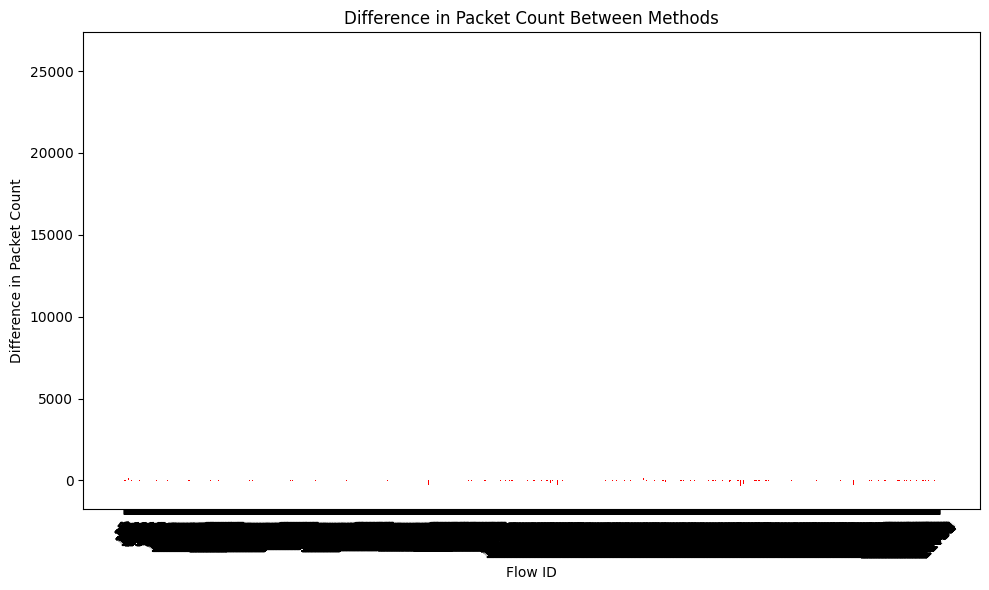

Flow ID 2: Różnica w liczbie pakietów = -1
Flow ID 3: Różnica w liczbie pakietów = -8
Flow ID 4: Różnica w liczbie pakietów = 24
Flow ID 5: Różnica w liczbie pakietów = -6
Flow ID 6: Różnica w liczbie pakietów = -8
Flow ID 7: Różnica w liczbie pakietów = -10
Flow ID 8: Różnica w liczbie pakietów = -5
Flow ID 9: Różnica w liczbie pakietów = 6
Flow ID 10: Różnica w liczbie pakietów = 1
Flow ID 11: Różnica w liczbie pakietów = -18
Flow ID 12: Różnica w liczbie pakietów = 6
Flow ID 13: Różnica w liczbie pakietów = 107
Flow ID 14: Różnica w liczbie pakietów = -1
Flow ID 15: Różnica w liczbie pakietów = -1
Flow ID 16: Różnica w liczbie pakietów = 11
Flow ID 17: Różnica w liczbie pakietów = -42
Flow ID 18: Różnica w liczbie pakietów = 10
Flow ID 19: Różnica w liczbie pakietów = -3
Flow ID 20: Różnica w liczbie pakietów = -5
Flow ID 21: Różnica w liczbie pakietów = 0
Flow ID 22: Różnica w liczbie pakietów = -148
Flow ID 23: Różnica w liczbie pakietów = -2
Flow ID 24: Różnica w liczbie pakietów

In [8]:
compare_flows(calculated_flows, csv_flows)

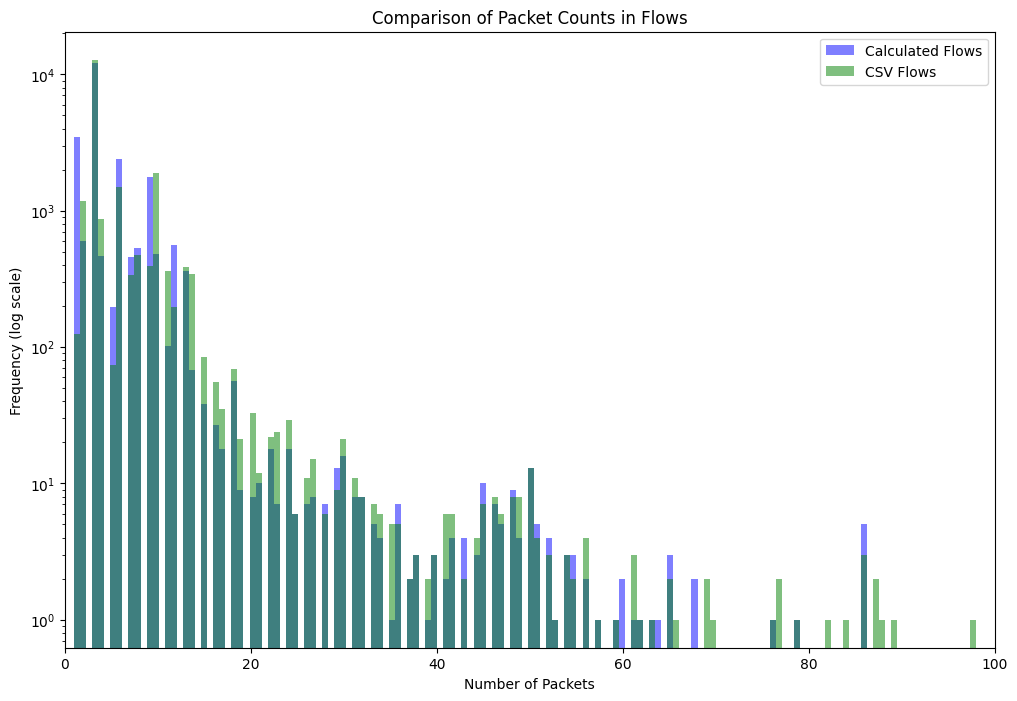

In [9]:
import matplotlib.pyplot as plt
import numpy as np  # Potrzebne do operacji na tablicach

def plot_histograms(calculated_flows, csv_flows):
    # Pobranie wartości ilości pakietów dla każdego flow_id z obu zbiorów danych
    calc_packets = [count for flow_id, count in calculated_flows.items()]
    csv_packets = [csv_flows[flow_id] for flow_id in calculated_flows.keys() if flow_id in csv_flows]

    # Tworzenie histogramów
    plt.figure(figsize=(12, 8))

    # Histogram dla danych z Pythona
    bins = np.histogram(np.hstack((calc_packets, csv_packets)), bins=40000)[1]  # Definiowanie wspólnych przedziałów dla obu zbiorów danych
    plt.hist(calc_packets, bins=bins, alpha=0.5, label='Calculated Flows', color='blue')

    # Histogram dla danych z CSV
    plt.hist(csv_packets, bins=bins, alpha=0.5, label='CSV Flows', color='green')

    # Dodanie legendy, tytułu i etykiet
    plt.yscale('log')  # Zmiana skali osi Y na logarytmiczną
    plt.xlabel('Number of Packets')
    plt.ylabel('Frequency (log scale)')
    plt.title('Comparison of Packet Counts in Flows')
    plt.legend()

    plt.xlim(0, 100)

    # Wyświetlenie wykresu
    plt.show()

# Przykład użycia
plot_histograms(calculated_flows, csv_flows)


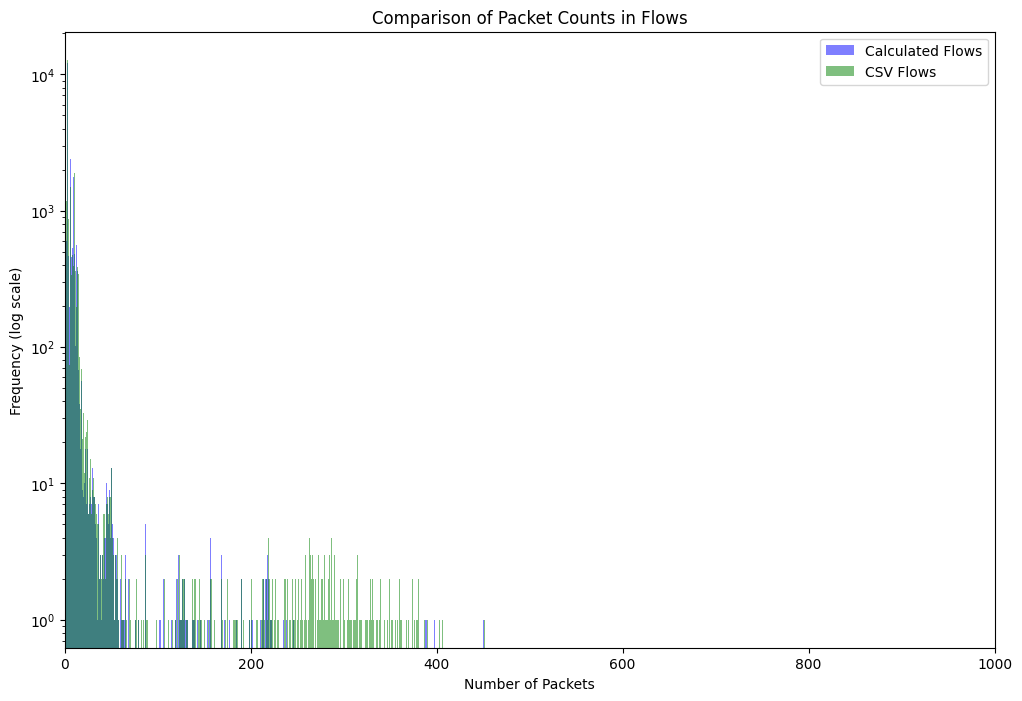

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(calculated_flows, csv_flows, num_bins=20):
    # Pobranie wartości ilości pakietów dla każdego flow_id z obu zbiorów danych
    calc_packets = [count for flow_id, count in calculated_flows.items()]
    csv_packets = [csv_flows[flow_id] for flow_id in calculated_flows.keys() if flow_id in csv_flows]

    # Tworzenie histogramów
    plt.figure(figsize=(12, 8))

    # Histogram dla danych z Pythona
    plt.hist(calc_packets, bins=num_bins, range=(0, 1000), alpha=0.5, label='Calculated Flows', color='blue')

    # Histogram dla danych z CSV
    plt.hist(csv_packets, bins=num_bins, range=(0, 1000), alpha=0.5, label='CSV Flows', color='green')

    # Dodanie legendy, tytułu i etykiet
    plt.yscale('log')  # Zmiana skali osi Y na logarytmiczną
    plt.xlabel('Number of Packets')
    plt.ylabel('Frequency (log scale)')
    plt.title('Comparison of Packet Counts in Flows')
    plt.legend()

    # Ustawienie limitów osi X
    plt.xlim(0, 1000)

    # Wyświetlenie wykresu
    plt.show()

# Przykład użycia z różną gęstością słupków
plot_histograms(calculated_flows, csv_flows, num_bins=1000)  # Możesz zmieniać 'num_bins' aby regulować gęstość słupków


In [11]:
# UNDER SAMPLE TESTING

In [12]:
#truncated_packets = undersample_flows_with_distribution(truncated_packets, 100)